In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import os
import warnings
warnings.filterwarnings('ignore')

2025-08-22 09:55:35.063840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755856535.335762      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755856535.414589      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
def f1_macro(y_true, y_pred):
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=3)
    
    if len(y_true_one_hot.shape) > 2:
        y_true_one_hot = tf.squeeze(y_true_one_hot, axis=[1])

    def recall_m(y_true, y_pred):
        TP = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        Positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
        recall = TP / (Positives + tf.keras.backend.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives + tf.keras.backend.epsilon())
        return precision
    
    # Pass the one-hot encoded y_true to the helper functions
    precision = precision_m(y_true_one_hot, y_pred)
    recall = recall_m(y_true_one_hot, y_pred)
    
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

In [4]:
df_up = pd.read_csv('/kaggle/input/credit-score-data/clean data/train_transformed_upsampled.csv')
df_test = pd.read_csv('/kaggle/input/credit-score-data/clean data/test_transformed.csv')

print(f"Upsampled training: {df_up.shape}")
print(f"Test: {df_test.shape}")

Upsampled training: (127725, 35)
Test: (20000, 35)


In [5]:
def prepare_data(df):
    X = df.drop('Credit_Score', axis=1)
    y = df['Credit_Score']
    return X, y

X_train_full, y_train_full = prepare_data(df_up)
X_test, y_test = prepare_data(df_test)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size=0.3, 
    random_state=42, 
    stratify=y_train_full
)

In [7]:
def build_model(input_shape):
    model = Sequential([
        Dense(512, input_shape=(input_shape,), activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),

        Dense(3, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001), 
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', f1_macro]
    )
    return model

In [8]:
input_shape = X_train.shape[1]
model = build_model(input_shape)

# Model summary
print(f"\nModel architecture:")
model.summary()


Model architecture:


2025-08-22 09:55:52.569694: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223,619 (873.51 KB)

 Trainable params: 223,619 (873.51 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
early_stopping = EarlyStopping(
    monitor='val_f1_macro',
    mode='max',
    patience=50,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    filepath='best_ann_model.keras',
    monitor='val_f1_macro',
    mode='max',
    save_best_only=True
)

In [10]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=400,
    batch_size=512,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

print(f"\nTraining completed!")
print(f"Total epochs trained: {len(history.history['loss'])}")

Epoch 1/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.6285 - f1_macro: 0.5316 - loss: 0.8695 - val_accuracy: 0.7199 - val_f1_macro: 0.7059 - val_loss: 0.7144
Epoch 2/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7142 - f1_macro: 0.7015 - loss: 0.7301 - val_accuracy: 0.7320 - val_f1_macro: 0.7216 - val_loss: 0.6827
Epoch 3/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7276 - f1_macro: 0.7197 - loss: 0.6913 - val_accuracy: 0.7400 - val_f1_macro: 0.7353 - val_loss: 0.6636
Epoch 4/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7337 - f1_macro: 0.7281 - loss: 0.6752 - val_accuracy: 0.7433 - val_f1_macro: 0.7377 - val_loss: 0.6490
Epoch 5/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7387 - f1_macro: 0.7328 - loss: 0.6584 - val_accuracy: 0.7481 - val_f1_macro: 0.7449 - val_loss: 0.6376
Epoch 6/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7424 - f1_macro: 0.7376 - loss: 0.6469 - val_accuracy: 0.7498 - val_f1_m

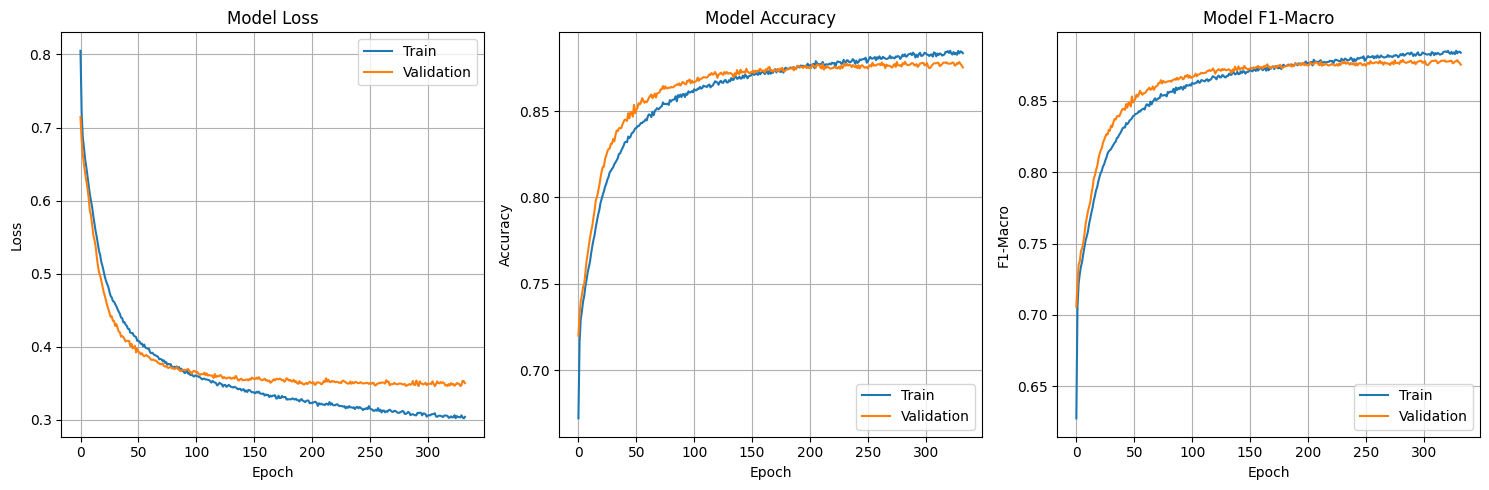

In [11]:
plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)

# Plot accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid(True)

# Plot F1-macro
plt.subplot(1, 3, 3)
plt.plot(history.history['f1_macro'])
plt.plot(history.history['val_f1_macro'])
plt.title('Model F1-Macro')
plt.ylabel('F1-Macro')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
y_train_pred_proba = model.predict(X_train)
y_val_pred_proba = model.predict(X_val)
y_train_full_pred_proba = model.predict(X_train_full)
y_test_pred_proba = model.predict(X_test)

# Convert probabilities to predictions
y_train_pred = np.argmax(y_train_pred_proba, axis=1)
y_val_pred = np.argmax(y_val_pred_proba, axis=1)
y_train_full_pred = np.argmax(y_train_full_pred_proba, axis=1)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

# Calculate metrics
train_acc = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred, average='macro')
val_acc = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='macro')
train_full_acc = accuracy_score(y_train_full, y_train_full_pred)
train_full_f1 = f1_score(y_train_full, y_train_full_pred, average='macro')
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='macro')

print(f"\n--- PERFORMANCE METRICS ---")
print(f"Training Set     - Accuracy: {train_acc:.4f}, F1-macro: {train_f1:.4f}")
print(f"Validation Set   - Accuracy: {val_acc:.4f}, F1-macro: {val_f1:.4f}")
print(f"Full Train Set   - Accuracy: {train_full_acc:.4f}, F1-macro: {train_full_f1:.4f}")
print(f"Test Set         - Accuracy: {test_acc:.4f}, F1-macro: {test_f1:.4f}")

print(f"\n--- FULL TRAINING SET CLASSIFICATION REPORT ---")
print(classification_report(y_train_full, y_train_full_pred, digits=4))

print(f"--- TEST SET CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_test_pred, digits=4))

2794/2794 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
3992/3992 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

--- PERFORMANCE METRICS ---
Training Set     - Accuracy: 0.9299, F1-macro: 0.9285
Validation Set   - Accuracy: 0.8786, F1-macro: 0.8762
Full Train Set   - Accuracy: 0.9145, F1-macro: 0.9128
Test Set         - Accuracy: 0.8002, F1-macro: 0.7961

--- FULL TRAINING SET CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0     0.8872    0.9667    0.9252     42575
           1     0.9361    0.8015    0.8636     42575
           2     0.9252    0.9754    0.9496     42575

    accuracy                         0.9145    127725
   macro avg     0.9162    0.9145    0.9128    127725
weighted avg     0.9162    0.9145    0.9128    127725

--- TEST SET CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0     0.7661    0.8813    0.8197      5874
       